In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from tqdm import tqdm

In [2]:
df = pd.read_csv('treated_BC5.csv')

In [ ]:
df.head()

In [ ]:
df.info()

In [3]:
df['Date'] =pd.to_datetime(df['Date'])

df['Quarter']=pd.PeriodIndex(df.Date, freq='Q')

## Quarter Analysis

In [6]:
MS_category = []
MS_family = []
Qty_products = []

for i in tqdm(df['Point-of-Sale_ID'].unique()):
    # Data from PoS i
    df_PoS = df[df['Point-of-Sale_ID']==i]
    
    ### market share - product category
    df2 = df_PoS.groupby(['Quarter','ProductCategory_ID'])['Price'].sum().reset_index()
    
    ## Total price by quarter
    total_per_quarter=df_PoS.groupby('Quarter')['Price'].sum()
    # Save
    df2['Sum'] = df2['Quarter'].replace(total_per_quarter)
    # Calculate Percentage
    df2['Percentage'] = df2['Price'] / df2['Sum']
    #Sort
    df2=df2.sort_values(by=['Percentage'], ascending=False)
    
    
    ### market share - product family
    df3 = df_PoS.groupby(['Quarter','ProductFamily_ID'])['Price'].sum().reset_index()
    
    # Save total price by quarter
    df3['Sum'] = df3['Quarter'].replace(total_per_quarter)
    # Calculate Percentage
    df3['Percentage'] = df3['Price'] / df3['Sum']
    #Sort
    df3=df3.sort_values(by=['Percentage'], ascending=False)

    # Quantity sold by each product in each Quarter
    Qty_products_PoS = pd.pivot_table(df_PoS, values='Unit', index=['ProductName_ID', 'Quarter'],aggfunc=np.sum).reset_index()
    
    # Save PoS ID
    df2['Point-of-Sale_ID'] = i
    df3['Point-of-Sale_ID'] = i
    Qty_products_PoS['Point-of-Sale_ID'] = i
    MS_category.append(df2)
    MS_family.append(df3)
    Qty_products.append(Qty_products_PoS)

100%|██████████| 410/410 [01:17<00:00,  5.27it/s]


In [8]:
df_final_MS_category = pd.concat(MS_category)
df_final_MS_family = pd.concat(MS_family)
df_final_Qty_products = pd.concat(Qty_products)

In [9]:
df_final_MS_category

,Quarter,ProductCategory_ID,Price,Sum,Percentage,Point-of-Sale_ID
837,2018Q3,178,3.514580e+07,4.371044e+07,0.804060,150
522,2017Q3,178,3.326533e+07,4.148050e+07,0.801951,150
448,2017Q2,178,3.247298e+07,4.058948e+07,0.800034,150
1067,2019Q2,178,3.341000e+07,4.196423e+07,0.796154,150
221,2016Q3,178,3.196437e+07,4.016763e+07,0.795774,150
...,...,...,...,...,...,...
531,2018Q3,14,7.320000e+02,3.418028e+07,0.000021,403
136,2016Q3,145,3.800000e+02,2.935484e+07,0.000013,403
626,2018Q4,138,3.990000e+02,3.448103e+07,0.000012,403
505,2018Q2,138,3.990000e+02,3.453027e+07,0.000012,403


In [11]:
df_final_MS_category.to_csv('MS_category.csv',index=False)
df_final_MS_family.to_csv('MS_family.csv',index=False)
df_final_Qty_products.to_csv('Qty_products.csv',index=False)

In [15]:
def long_tail_plot(df, item_id_column, percentage=None, x_labels=True, colors=('blue','green')):
    """
    Plots the long tail for a user-item interaction dataset.
    ----------
    df: pandas dataframe
        user-item interaction dataframe
        example:
    item_id_column: str
        column name identifying the item ids in the dataframe
    percentage: float, default=None
        percent of volume to consider as the head (percent as a decimal)
        (if default=None no line will be plotted)
    x_labels: bool, default=True
        if True, plot x-axis tick labels
        if False, no x-axis tick lavels will be plotted.
    colors: tuple of color strings to color the head (0) and tail (1).
    Returns:
    -------
        A long tail plot
        
    
    Credits: https://github.com/statisticianinstilettos/recmetrics/blob/master/recmetrics/plots.py
    """
    #calculate cumulative volumes
    volume_df = df[item_id_column].value_counts().reset_index()
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()

    #line plot of cumulative volume
    x=range(0,len(volume_df))
    ax = plt.subplots(figsize = (20,15))
    ax = sns.lineplot(x, y="volume", data=volume_df, color="black")
    plt.xticks(x)

    #set labels
    #ax.set_title('Long Tail Plot',size=20)
    ax.set_ylabel('Number of Transactions', size=18)
    ax.set_xlabel('Products', size=18)

    if percentage != None:
        #plot vertical line at the tail location
        head = volume_df[volume_df["percent_of_total_volume"] <= percentage]
        tail = volume_df[volume_df["percent_of_total_volume"] > percentage]
        items_in_head = len(head)
        items_in_tail = len(tail)
        plt.axvline(x=items_in_head, color="red",  linestyle='--')

        # fill area under plot
        head = head.append(tail.head(1))
        x1 = head.index.values
        y1 = head['volume']
        x2 = tail.index.values
        y2 = tail['volume']
        ax.fill_between(x1, y1, color="mediumturquoise", alpha=0.3)
        ax.fill_between(x2, y2,  color="plum", alpha=0.3)

        #create legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': products in the head', markerfacecolor=colors[0], markersize=15),
                           Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': products in the tail', markerfacecolor=colors[1], markersize=15)]
        ax.legend(handles=legend_elements, loc=1,prop={'size': 22})

    else:
        x1 = volume_df[item_id_column]
        y1 = volume_df['volume']
        ax.fill_between(x1, y1, color="mediumturquoise", alpha=0.3)
    if x_labels == False:
        plt.xticks([], [])
        ax.set(xticklabels=[])
    else:
        ax.set_xticklabels(labels = volume_df[item_id_column], rotation = 45, ha="right")

    plt.show()

C:\Users\betty\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


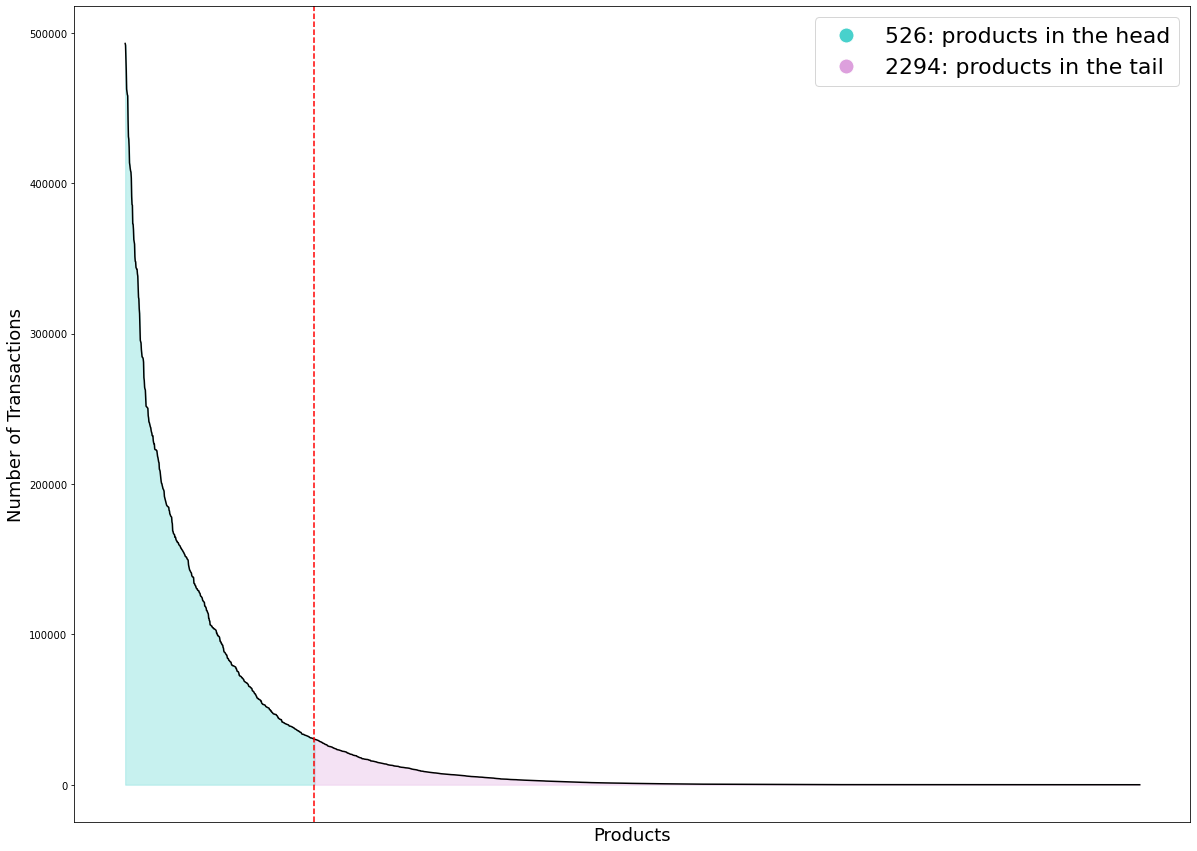

In [18]:
long_tail_plot(df, 'ProductName_ID', percentage= 0.9, x_labels= False, colors= ('mediumturquoise','plum'))

## MBA Family for each quarter, using PoS+Date as the "basket" and with a minimum support of 0.6

In [4]:
df['Order_ID'] = df['Date'].astype(str) + '-' + df['Point-of-Sale_ID'].astype(str)

In [ ]:
# did this for every quarter to construct a dataframe
i = '2016Q2'
# Data from Quarter i
df_PoS = df[df['Quarter'] == i][['Order_ID','ProductFamily_ID']]
pivot_PoS = pd.pivot_table(df_PoS, index=['Order_ID'], columns='ProductFamily_ID', 
                            aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 60% of the transactions
frequent_itemsets = apriori(pivot_PoS, min_support=0.6, use_colnames=True, verbose=1, low_memory = True)
# length of the itemsets
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x)) 
# Generate the association rules - by lift
rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)
rulesLift.sort_values(by='lift', ascending=False, inplace=True)
assoc_to_append = rulesLift[['antecedents','consequents','antecedent support','consequent support',
                                'support','confidence','lift']]
assoc_to_append['Quarter'] = i

In [ ]:
q22016 = pd.DataFrame(assoc_to_append)
q22016

In [ ]:
q22016.to_csv('Association_Rules_q2_2016.csv',index=False)

In [38]:
#reading them all
q1 = pd.read_csv('Association_Rules_q1_2016.csv')
q2 = pd.read_csv('Association_Rules_q2_2016.csv')
q3 = pd.read_csv('Association_Rules_q3_2016.csv')
q4 = pd.read_csv('Association_Rules_q4_2016.csv')
q5 = pd.read_csv('Association_Rules_q1_2017.csv')
q6 = pd.read_csv('Association_Rules_q2_2017.csv')
q7 = pd.read_csv('Association_Rules_q3_2017.csv')
q8 = pd.read_csv('Association_Rules_q4_2017.csv')
q9 = pd.read_csv('Association_Rules_q1_2018.csv')
q10 = pd.read_csv('Association_Rules_q2_2018.csv')
q11 = pd.read_csv('Association_Rules_q3_2018.csv')
q12 = pd.read_csv('Association_Rules_q4_2018.csv')
q13 = pd.read_csv('Association_Rules_q1_2019.csv')
q14 = pd.read_csv('Association_Rules_q2_2019.csv')
q15 = pd.read_csv('Association_Rules_q3_2019.csv')
q16 = pd.read_csv('Association_Rules_q4_2019.csv')

In [39]:
# only the top 50 with higher lift
assocrulesfam = pd.concat([q1[:50],q2[:50],q3[:50],q4[:50],q5[:50],q6[:50],q7[:50],q8[:50],q9[:50],q10[:50],q11[:50],q12[:50],q13[:50],q14[:50],q15[:50],q16[:50]], ignore_index = True)

In [40]:
assocrulesfam['antecedents'] = assocrulesfam['antecedents'].apply(lambda x: x[10:-1])
assocrulesfam['consequents'] = assocrulesfam['consequents'].apply(lambda x: x[10:-1])

In [41]:
assocrulesfam

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Quarter
0,"{1, 8, 12, 15, 16, 18, 21}","{2, 5, 6, 9, 14}",0.763997,0.699360,0.608693,0.796722,1.139216,2016Q1
1,"{2, 5, 6, 9, 14}","{1, 8, 12, 15, 16, 18, 21}",0.699360,0.763997,0.608693,0.870357,1.139216,2016Q1
2,"{2, 6, 9, 16, 18, 21}","{1, 5, 8, 12, 14, 15}",0.744447,0.717730,0.608693,0.817645,1.139211,2016Q1
3,"{1, 5, 8, 12, 14, 15}","{2, 6, 9, 16, 18, 21}",0.717730,0.744447,0.608693,0.848081,1.139211,2016Q1
4,"{1, 2, 6, 9, 16, 18, 21}","{5, 8, 12, 14, 15}",0.744419,0.717757,0.608693,0.817675,1.139209,2016Q1
...,...,...,...,...,...,...,...,...
795,"{8, 18, 3, 6}","{2, 5, 9, 14, 15, 21}",0.771896,0.725963,0.627326,0.812708,1.119489,2019Q4
796,"{8, 18, 3, 6}","{2, 5, 9, 12, 14, 15, 21}",0.771896,0.725963,0.627326,0.812708,1.119489,2019Q4
797,"{8, 18, 3, 6}","{1, 2, 5, 9, 12, 14, 15, 21}",0.771896,0.725963,0.627326,0.812708,1.119489,2019Q4
798,"{3, 6, 8, 12, 18}","{1, 2, 5, 9, 14, 15, 21}",0.771896,0.725963,0.627326,0.812708,1.119489,2019Q4


In [42]:
assocrulesfam.to_csv('Association_Rules_Families.csv',index=False)

## MBA Category for each quarter, using PoS+Date as the "basket" and with a minimum support of 0.6

In [5]:
# did this for every quarter to construct a dataframe
i = '2019Q4'
# Data from Quarter i
df_PoS = df[df['Quarter'] == i][['Order_ID','ProductCategory_ID']]
pivot_PoS = pd.pivot_table(df_PoS, index=['Order_ID'], columns='ProductCategory_ID', 
                            aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 60% of the transactions
frequent_itemsets = apriori(pivot_PoS, min_support=0.6, use_colnames=True, verbose=1, low_memory = True)
# length of the itemsets
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x)) 
# Generate the association rules - by lift
rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)
rulesLift.sort_values(by='lift', ascending=False, inplace=True)
assoc_to_append = rulesLift[['antecedents','consequents','antecedent support','consequent support',
                                'support','confidence','lift']]
assoc_to_append['Quarter'] = i

Processing 30 combinations | Sampling itemset size 987


<ipython-input-5-4f2d9028f0b9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assoc_to_append['Quarter'] = i


In [6]:
q42019 = pd.DataFrame(assoc_to_append)
q42019

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Quarter
2263,"(34, 3, 178, 22, 27, 28)","(2, 18, 175)",0.764578,0.707591,0.603503,0.789329,1.115517,2019Q4
2430,"(2, 18, 175)","(34, 3, 178, 22, 27, 28)",0.707591,0.764578,0.603503,0.852899,1.115517,2019Q4
1411,"(34, 3, 22, 27, 28)","(2, 18, 175)",0.764578,0.707591,0.603503,0.789329,1.115517,2019Q4
2369,"(178, 2, 18, 175)","(34, 3, 22, 27, 28)",0.707591,0.764578,0.603503,0.852899,1.115517,2019Q4
1470,"(2, 18, 175)","(34, 3, 22, 27, 28)",0.707591,0.764578,0.603503,0.852899,1.115517,2019Q4
...,...,...,...,...,...,...,...,...
648,"(178, 34, 28)","(18, 2, 3, 175)",0.802258,0.693110,0.611678,0.762445,1.100035,2019Q4
639,"(18, 2, 3, 175)","(178, 34, 28)",0.693110,0.802258,0.611678,0.882512,1.100035,2019Q4
1746,"(178, 34, 28)","(2, 3, 175, 18, 27)",0.802258,0.693110,0.611678,0.762445,1.100035,2019Q4
2223,"(2, 3, 34, 175, 22, 27, 28)","(178, 18)",0.746594,0.734838,0.603503,0.808342,1.100027,2019Q4


In [7]:
q42019.to_csv('Association_Rules_q4_2019_cat.csv',index=False)

In [27]:
#reading them all
qq1 = pd.read_csv('Association_Rules_q1_2016_cat.csv')
qq2 = pd.read_csv('Association_Rules_q2_2016_cat.csv')
qq3 = pd.read_csv('Association_Rules_q3_2016_cat.csv')
qq4 = pd.read_csv('Association_Rules_q4_2016_cat.csv')
qq5 = pd.read_csv('Association_Rules_q1_2017_cat.csv')
qq6 = pd.read_csv('Association_Rules_q2_2017_cat.csv')
qq7 = pd.read_csv('Association_Rules_q3_2017_cat.csv')
qq8 = pd.read_csv('Association_Rules_q4_2017_cat.csv')
qq9 = pd.read_csv('Association_Rules_q1_2018_cat.csv')
qq10 = pd.read_csv('Association_Rules_q2_2018_cat.csv')
qq11 = pd.read_csv('Association_Rules_q3_2018_cat.csv')
qq12 = pd.read_csv('Association_Rules_q4_2018_cat.csv')
qq13 = pd.read_csv('Association_Rules_q1_2019_cat.csv')
qq14 = pd.read_csv('Association_Rules_q2_2019_cat.csv')
qq15 = pd.read_csv('Association_Rules_q3_2019_cat.csv')
qq16 = pd.read_csv('Association_Rules_q4_2019_cat.csv')

In [43]:
assocrulescat = pd.concat([qq1[:50],qq2[:50],qq3[:50],qq4[:50],qq5[:50],qq6[:50],qq7[:50],qq8[:50],qq9[:50],qq10[:50],qq11[:50],qq12[:50],qq13[:50],qq14[:50],qq15[:50],qq16[:50]], ignore_index = True)

In [44]:
assocrulescat['antecedents'] = assocrulescat['antecedents'].apply(lambda x: x[10:-1])
assocrulescat['consequents'] = assocrulescat['consequents'].apply(lambda x: x[10:-1])

In [45]:
assocrulescat

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Quarter
0,"{1, 34, 3, 178, 27}","{18, 22, 175}",0.722837,0.745929,0.603009,0.834226,1.118371,2016Q1
1,"{18, 22, 175}","{1, 34, 3, 178, 27}",0.745929,0.722837,0.603009,0.808400,1.118371,2016Q1
2,"{18, 22, 175}","{27, 1, 34, 3}",0.745929,0.722837,0.603009,0.808400,1.118371,2016Q1
3,"{178, 18, 22, 175}","{27, 1, 34, 3}",0.745929,0.722837,0.603009,0.808400,1.118371,2016Q1
4,"{27, 1, 34, 3}","{178, 18, 22, 175}",0.722837,0.745929,0.603009,0.834226,1.118371,2016Q1
...,...,...,...,...,...,...,...,...
641,"{2, 3, 34, 28}","{18, 27, 22, 175}",0.768470,0.705255,0.603503,0.785331,1.113542,2019Q4
642,"{18, 27, 22, 175}","{2, 3, 34, 178, 28}",0.705255,0.768470,0.603503,0.855724,1.113542,2019Q4
643,"{18, 27, 22, 175}","{2, 3, 34, 28}",0.705255,0.768470,0.603503,0.855724,1.113542,2019Q4
644,"{2, 175, 178, 18, 22}","{27, 34, 3, 28}",0.692020,0.783184,0.603503,0.872089,1.113517,2019Q4


In [46]:
assocrulescat.to_csv('Association_Rules_Categories.csv',index=False)

In [17]:
bla[bla['confidence']<0.6]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Quarter


In [18]:
bla

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Quarter
0,"{1, 8, 12, 15, 16, 18, 21}","{2, 5, 6, 9, 14}",0.763997,0.699360,0.608693,0.796722,1.139216,2016Q1
1,"{2, 5, 6, 9, 14}","{1, 8, 12, 15, 16, 18, 21}",0.699360,0.763997,0.608693,0.870357,1.139216,2016Q1
2,"{2, 6, 9, 16, 18, 21}","{1, 5, 8, 12, 14, 15}",0.744447,0.717730,0.608693,0.817645,1.139211,2016Q1
3,"{1, 5, 8, 12, 14, 15}","{2, 6, 9, 16, 18, 21}",0.717730,0.744447,0.608693,0.848081,1.139211,2016Q1
4,"{1, 2, 6, 9, 16, 18, 21}","{5, 8, 12, 14, 15}",0.744419,0.717757,0.608693,0.817675,1.139209,2016Q1
...,...,...,...,...,...,...,...,...
6766591,"{1, 10, 3, 12}","{9, 2, 21, 5}",0.750564,0.726820,0.600078,0.799502,1.100001,2019Q4
6766592,"{10, 3, 12}","{1, 2, 5, 9, 21}",0.750564,0.726820,0.600078,0.799502,1.100001,2019Q4
6766593,"{1, 10, 3}","{2, 5, 9, 12, 21}",0.750564,0.726820,0.600078,0.799502,1.100001,2019Q4
6766594,"{9, 2, 21, 5}","{1, 10, 3, 12}",0.726820,0.750564,0.600078,0.825621,1.100001,2019Q4


In [19]:
blu = pd.read_csv('Association_Rules_Categories.csv')

In [26]:
bla['lift'].max()

1.1513841071105693